In this competition, we are predicting whether a given tweet is about a real disaster (1) or not (0).

Tweets are short messages, restricted to 140 characters in length. Due to the nature of this microblogging service
(quick and short messages), people use acronyms, make spelling mistakes, use emoticons and other characters that
express special meanings. Following is a brief terminology associated with tweets. 
* Emoticons: These are facial expressions pictorially represented using punctuation and letters; they express the user’s mood. 
* Target: Users of Twitter use the “@” symbol to refer to other users on the microblog. Referring to other users in this manner automatically alerts them. 
* Hashtags: Users usually use hashtags to mark topics. This is primarily done to increase the visibility of their tweets.

A single tweet contains a lot of information related to users, the text of the tweet, created date of the tweet, the
location of the tweet and many more fields. This competition's dataset has the following fields:
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Tweets can also be retweeted. A retweet is a reposted or forwarded message.

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.layers import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import optuna

# Set pandas configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set constants
seed = 1356
TUNING_RNN = False
TUNING_BRNN = True

# 1. Load & clean data

In [ ]:
train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
test = pd.read_csv('drive/MyDrive/nlp-getting-started/test.csv')
full = pd.concat([train,test]).reset_index()
full.drop('index',axis=1,inplace=True)
HTML(full.sample(n=5, random_state=42).sort_values(by='id').to_html(index=False)) #using HTML/to_html to hide the index

id,keyword,location,text,target
2039,casualties,NaN,@AlcoholAndMetal + do anything to fix that. Of the few people he had every trusted in his life Charles was one of the casualties.,1.0
3799,detonate,"Nashville, Music City, USA",@HJudeBoudreaux Start your car with it! Or use it to detonate an evil henchman!!,NaN
4192,drown,"Austin, TX",absolute drown your Wagyu steak in heaping piles of moist Smuckers Grape Jam,NaN
6403,hurricane,"The Epicenter, and Beyond",AD Miles 'Hurricane of Fun : The Making of Wet Hot' https://t.co/SBZwRuwuFh,0.0
8687,sinkhole,NaN,Watch This Giant Sinkhole Form on New York City Street http://t.co/BEnWu5IARa,NaN


Let's build a new dataframe with a column `ori_text` containing the original text, a new column `text` containing the cleaned/processed text and a few additional metadata columns: `user`,`url`, `hashtag`,`emoticon`. Then we can pick randomly 5 records from this dataframe and display them:

In [ ]:
def clean_data(df):

    # Copy the original text before processing it
    df['ori_text'] = df['text']

    # Add a new tweet meta-data with user + replace @xxx by <user> 
    df['user'] = df['text'].str.findall('@\w+')
    df['text'] = df['text'].str.replace('@\w+', '', regex=True)

    # Add a new tweet meta-data with url + remove url from the text
    df['url'] = df['text'].str.findall('https?://t.co/\w+')
    df['text'] = df['text'].str.replace('https?://t.co/\w+', '', regex=True)

    # Add a new tweet meta-data with emoticons + remove emoticons from the text
    # https://support.microsoft.com/fr-fr/office/raccourcis-clavier-d-%C3%A9motic%C3%B4ne-5dbe678c-cef7-4a63-aa62-f07c2f38b267
    emoticons_dict = {
        'smile': ':-?\)',             # :) or :-) 
        'winking': ';-?\)',           # ;) or ;-)
        'playful': ':-?D',            # :D or :-D
        'idiot': ':-?P',              # :P or :-P
        'sad': ':-?\(',               # :( or :-(
        'surprised': ':-?O|O[_.]O',   # :O or :-O or O_O or O.O
        'lol': '[xX]D',               # xD or XD
        'crying': ':\'-?\(',          # :'( or :'-(  
    }

    for k in emoticons_dict:
        colname = 'emoticon_' + k
        df[colname] = df['text'].str.findall(emoticons_dict[k])
        df['text'] = df['text'].str.replace(emoticons_dict[k], '', regex=True)

    # Replace the columns emoticon_xxx with one column emoticon
    df['emoticon']=''
    for i in df.index:
        for k in emoticons_dict:
            colname = 'emoticon_' + k
            if(len(df.loc[i][colname])>0):
                df.loc[i,'emoticon']=k
    
    for k in emoticons_dict:
        colname = 'emoticon_' + k
        df.drop(colname,axis=1,inplace=True)
            
    # Add a new tweet meta-data with hashtag + remove # from the text 
    df['hashtag'] = df['text'].str.findall('#\w+')
    repl = lambda h: h[0][1:]
    df['text'] = df['text'].str.replace('#\w+', repl, regex=True)

    # Force splitting words appended with slashes (once we removed the url, of course)
    df['text'] = df['text'].str.replace('/', ' / ', regex=True)

    # Replace &amp; by and
    df['text'] = df['text'].str.replace('&amp;', ' and ', regex=True) # &amp;

    # Remove &gt; and &lt;
    df['text'] = df['text'].str.replace('&[lg]t;', ' ', regex=True) # &gt; &lt;

    # Handle sequences like '\x89ÛÏ'
    dec = lambda t: t.encode('ascii', 'ignore').decode('utf-8')
    df['text'] = df['text'].apply(lambda text: dec(text))

    # Replace \n by point
    df['text'] = df['text'].str.replace('\n', '.', regex=True) # \n

    # Replace '  ' by ' '
    df['text'] = df['text'].str.replace('  ', ' ', regex=True) # multiple spaces
    
    return df.copy()

In [ ]:
full = clean_data(full)

# Create the new train and test sets
train = full[full['target'].isnull()==False]
test = full[full['target'].isnull()]

# Let's check the output of our data processing
diff = full[full['ori_text']!=full['text']]
diff.to_csv('diff.csv')
HTML(diff.sample(n=5, random_state=63).sort_values(by='id').to_html(index=False))

id,keyword,location,text,target,ori_text,user,url,emoticon,hashtag
525,army,"Bowling Green, Ky",Hope the Salvation Army at least gave you a tax receipt.,NaN,Hope the Salvation Army at least gave you a tax receipt. https://t.co/Ir9c545rZy,[],[https://t.co/Ir9c545rZy],,[]
850,bioterror,"Washington, D.C., area",Latest fallout from biolab safety lapses: FedEx no longer will transport anthrax and select agent research specimens,NaN,Latest fallout from biolab safety lapses: FedEx no longer will transport anthrax &amp; select agent research specimens http://t.co/4iOOyIbxyo,[],[http://t.co/4iOOyIbxyo],,[]
2393,collapsed,Hong Kong,3-pronged inquiry launched into collapsed HongKong furniture retailer DSC,NaN,3-pronged inquiry launched into collapsed #HongKong furniture retailer DSC http://t.co/Tg3ukIsgEN @scmp_news http://t.co/An5LpimNfA,[@scmp_news],"[http://t.co/Tg3ukIsgEN, http://t.co/An5LpimNfA]",,[#HongKong]
6593,inundated,"Boston, Massachusetts",Body shops inundated with cars dented by hail... Good news insurance pays... Bad news : you are stuck with deductible !.wcvb,1.0,Body shops inundated with cars dented by hail... Good news insurance pays... Bad news : you are stuck with deductible !\n#wcvb,[],[],,[#wcvb]
9643,thunderstorm,"Tornado Alley, USA",Severe Thunderstorm Warning for Oklahoma County in OK until 10:30pm CDT. okwx,1.0,Severe Thunderstorm Warning for Oklahoma County in OK until 10:30pm CDT. #okwx,[],[],,[#okwx]


# 2. EDA

## 2.1 Basic Insights

A quick analysis of this dataset shows:
* there are 10876 tweets in the dataset.
* the train set has 7613 records (70%) and the test set 3263 (30%).
* the train set is fairly balanced (43% / 57%) : 3271 positive examples (disasters) vs 4342 negative examples.
* `keyword` and `location` have missing values. 
* `location` has very likely no predictive power and can be ignored.
* `keyword` may have some predictive power.

## 2.2 Retweets

In the training set, there are 305 tweet texts that are repeated twice or more:

In [ ]:
train.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612],
           dtype='int64', length=7613)

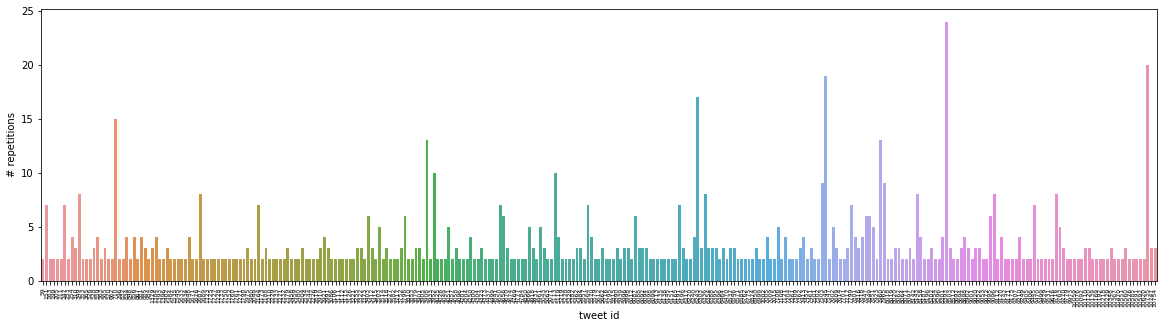

In [ ]:
retweets = {}
for i in train.index:
    t = train.iloc[i]['text']
    indexes = train[(train['text']==t)].index.values
    if len(indexes)>1:
        retweets[indexes[0]]=indexes # using indexes[0] is a simple trick to avoid duplicates
#retweets
retweets_viz = pd.DataFrame({'tweet id': retweets.keys(), '# repetitions': retweets.values()})
retweets_viz['tweet id'] = retweets_viz['tweet id'].apply(lambda index: train.iloc[index]['id'])
retweets_viz['# repetitions'] = retweets_viz['# repetitions'].apply(lambda lst: len(lst))
#retweets_viz
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=retweets_viz, x='tweet id', y='# repetitions', ax=ax)
plt.xticks(rotation=90, fontsize=6)
plt.show()

E.g. let's display the tweet with id=881 and its retweets. One interesting (problematic) thing to notice is that the same tweets have different targets!!

In [ ]:
t = train[train['id']==881]['text'].item()
HTML(train[train['text']==t].to_html(index=False))

id,keyword,location,text,target,ori_text,user,url,emoticon,hashtag
881,bioterrorism,NaN,To fight bioterrorism sir.,1.0,To fight bioterrorism sir.,[],[],,[]
898,bioterrorism,NaN,To fight bioterrorism sir.,0.0,To fight bioterrorism sir.,[],[],,[]
907,bioterrorism,NaN,To fight bioterrorism sir.,1.0,To fight bioterrorism sir.,[],[],,[]
916,bioterrorism,NaN,To fight bioterrorism sir.,0.0,To fight bioterrorism sir.,[],[],,[]


Let's check the extent of the problem: 71 tweet texts are repeated twice or more and have inconsistent labels:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.


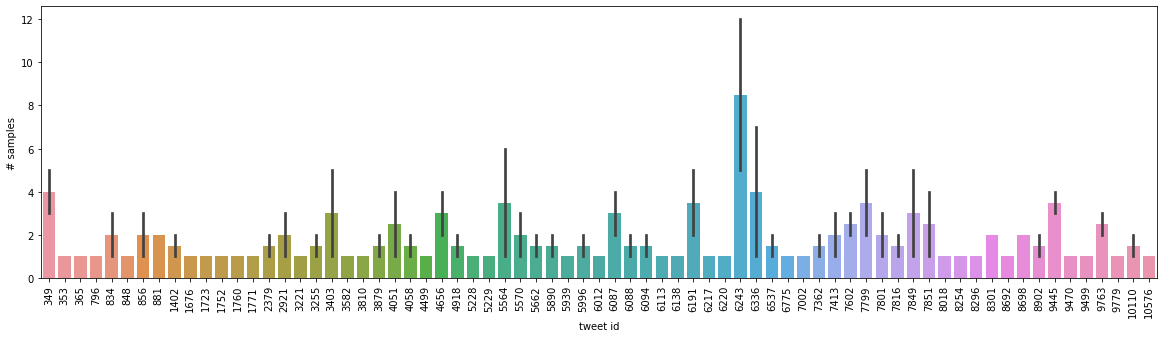

In [ ]:
retweets_target={}
target_0 = 0
target_1 = 0
for k in retweets.keys():
    for i in range(0, len(retweets[k])):
        target = train.iloc[retweets[k][i]]['target']
        if target==0:
            target_0 = target_0 + 1
        else:
            target_1 = target_1 + 1
    retweets_target[k] = [target_0,target_1]
    target_0 = 0
    target_1 = 0
#retweets_target

retweets_target_viz = pd.DataFrame({'tweet id': retweets_target.keys(), 'target 0': retweets_target.values(), 'target 1': retweets_target.values()})
retweets_target_viz['tweet id'] = retweets_target_viz['tweet id'].apply(lambda index: train.iloc[index]['id'])
retweets_target_viz['target 0'] = retweets_target_viz['target 0'].apply(lambda lst: lst[0])
retweets_target_viz['target 1'] = retweets_target_viz['target 1'].apply(lambda lst: lst[1])
#retweets_target_viz

inconsistent_labels = retweets_target_viz[(retweets_target_viz['target 0']>0) & (retweets_target_viz['target 1']>0)]
#inconsistent_labels

inconsistent_labels_viz = inconsistent_labels.melt('tweet id', var_name='target 0', value_name='target 1')
inconsistent_labels_viz = inconsistent_labels_viz.rename({'target 0': 'target', 'target 1': '# samples'}, axis=1)
#inconsistent_labels_viz[inconsistent_labels_viz['tweet id']==349]

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(data=inconsistent_labels_viz, x='tweet id', y='# samples', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Now, let's find tweet text in train set that are also in test set:

In [ ]:
retweets_target_viz

,tweet id,target 0,target 1
0,59,2,0
1,151,7,0
2,163,2,0
3,199,0,2
4,205,0,2
...,...,...,...
300,10592,0,2
301,10620,0,2
302,10735,0,20
303,10747,0,3


In [ ]:
inconsistent_labels_viz

,tweet id,target,# samples
0,349,target 0,5
1,353,target 0,1
2,365,target 0,1
3,796,target 0,1
4,834,target 0,1
...,...,...,...
137,9499,target 1,1
138,9763,target 1,2
139,9779,target 1,1
140,10110,target 1,1


In [ ]:
retweets_full = {}
for i in full.index:
    t = full.iloc[i]['text']
    indexes = full[(full['text']==t)].index.values
    if len(indexes)>1:
        retweets_full[indexes[0]]=indexes # using indexes[0] is a simple trick to avoid duplicates
#retweets_full

retweets_full = pd.DataFrame({'tweet id in training set': retweets_full.values(), 'tweet id in test set': retweets_full.values()})
train_last_index = train.shape[0]
retweets_full['tweet id in training set'] = retweets_full['tweet id in training set'].apply(lambda indexes: [i for i in indexes if i<train_last_index+1])
retweets_full['tweet id in test set'] = retweets_full['tweet id in test set'].apply(lambda indexes: [i for i in indexes if i>train_last_index])

#substitution of indexes by id
def replace_by_id(indexes):
    ids=[]
    for i in range(0,len(indexes)):
        index = indexes[i]
        ids.append(full.iloc[index]['id'])
    return ids

retweets_full['tweet id in training set'] = retweets_full['tweet id in training set'].apply(lambda indexes: replace_by_id(indexes))
retweets_full['tweet id in test set'] = retweets_full['tweet id in test set'].apply(lambda indexes: replace_by_id(indexes))
#retweets_full

#keep only the tweet text in train set that are also in test set
indexes_to_drop=[]
for i in retweets_full.index:
    train_ids = retweets_full.iloc[i]['tweet id in training set']
    test_ids = retweets_full.iloc[i]['tweet id in test set']
    if (len(train_ids)==0 or len(test_ids)==0):
        indexes_to_drop.append(i)
#indexes_to_drop
retweets_full.drop(index=indexes_to_drop,inplace=True)
retweets_full.reset_index(inplace=True)
retweets_full.drop('index',axis=1,inplace=True)
retweets_full

,tweet id in training set,tweet id in test set
0,"[59, 68]",[58]
1,"[151, 156, 164, 165, 168, 171, 172]","[152, 155, 177]"
2,[153],[181]
3,"[163, 190]","[179, 192]"
4,"[199, 229]","[234, 239]"
...,...,...
268,"[10747, 10765, 10770]",[10757]
269,"[10754, 10771, 10776]","[10738, 10758]"
270,[10774],[10742]
271,[10851],[9628]


In [ ]:
retweets_full

,tweet id in training set,tweet id in test set
0,"[59, 68]",[58]
1,"[151, 156, 164, 165, 168, 171, 172]","[152, 155, 177]"
2,[153],[181]
3,"[163, 190]","[179, 192]"
4,"[199, 229]","[234, 239]"
...,...,...
268,"[10747, 10765, 10770]",[10757]
269,"[10754, 10771, 10776]","[10738, 10758]"
270,[10774],[10742]
271,[10851],[9628]


## 2.3 Emoticons

Let's display the count of tweets per emoticon and per target:

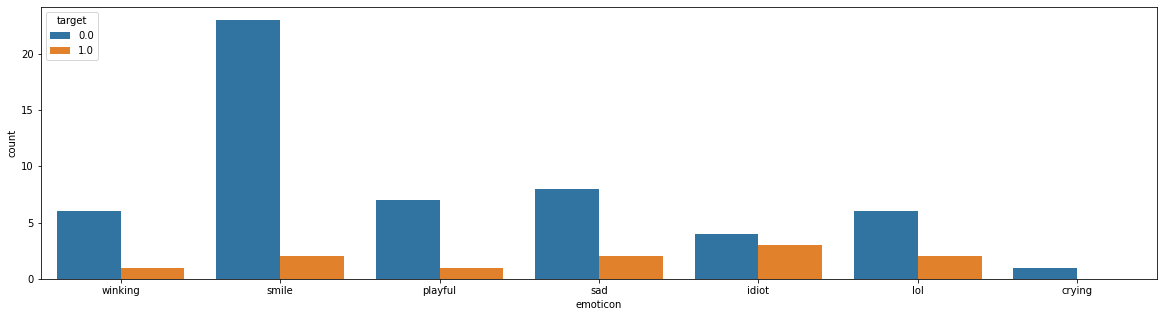

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(data=train[train['emoticon']!=''], x='emoticon', hue='target')
plt.show()

# 3. Prepare dataset for model training and evaluation

In [ ]:
train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
train = clean_data(train)

## 3.1 Remove duplicates from the training set

In [ ]:
def remove_duplicates(df, retweets):
    old_nb_samples = df.shape[0]
    # retweets is a dictionary holding the duplicates
    indexes_to_drop=[]
    for k in retweets.keys():
        for i in range(0,len(retweets[k])):
            if i>0:
                indexes_to_drop.append(retweets[k][i])
    #indexes_to_drop
    df.drop(index=indexes_to_drop,inplace=True)
    new_nb_samples = df.shape[0]
    return df, old_nb_samples, new_nb_samples

There are 305 tweet texts that are repeated twice or more in the training set. So let's remove the duplicates (and keep one sample).


In [ ]:
train, old_nb_training_samples, new_nb_training_samples = remove_duplicates(train, retweets)
print('Nb of duplicates removed : ' + str(old_nb_training_samples-new_nb_training_samples))

Nb of duplicates removed : 677


## 3.2 Remove samples with inconsistent labels from the training set

In [ ]:
def remove_inconsistent_labels(df, inconsistent_labels):
    # inconsistent_labels holds the ids of the tweets that appear twice or more with inconsistent labels.
    old_nb_samples = df.shape[0]
    indexes_to_drop = df[df['id'].isin(inconsistent_labels['tweet id'])].index
    df.drop(index=indexes_to_drop,inplace=True)
    new_nb_samples = df.shape[0]
    return df, old_nb_samples, new_nb_samples

In [ ]:
train, old_nb_training_samples, new_nb_training_samples = remove_inconsistent_labels(train, inconsistent_labels)
print('Nb of samples removed : ' + str(old_nb_training_samples-new_nb_training_samples))

Nb of samples removed : 71


## 3.3 Create a validation split

Let's load the train and test data and split the train data into a training and a validation datasets with 20% of samples going to the validation dataset and 80% going to the training dataset:

In [ ]:
# Set constants
seed = 1356
TUNING_RNN = False
TUNING_BRNN = True

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.2, shuffle=True, random_state=seed)

We use the utility `tf.data.Dataset.from_tensor_slices` to generate a labeled `tf.data.Dataset` object from dataframes. Now, let's preview a few samples:

In [ ]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(text_batch[i].numpy())
        print(label_batch[i].numpy())

b"I'm so traumatised."
0
b"At FEMA's Center for Disaster Preparedness for a weeklong training on Chemical Biological Radioactive Nuclear  Emergency Response"
1
b'just got engulfed in a car-induced tidal wave on my run... I thought this only happened in the movies ????'
0
b" Everything must be OK because she's listening to 'Sandstorm' now..."
0
b'Save your riches in heaven where they will never decrease because no thief can gets them and no moth can destroy them. ??'
0


# 4. Create a vocabulary index

We can instantiate the text vectorization layer. This layer will be used to split tweets into words (tokens) and then map words to integers (output_mode='int'). Note that we are using the default standardization `lower_and_strip_punctuation` and split `whitespace` functions:

In [ ]:
vectorize_layer = TextVectorization(output_mode="int")

We call `adapt()` on a text-only dataset to create the vocabulary. Here what matters is to create the vocabulary using only the training dataset (not the validation one):

In [ ]:
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

Let's display the vocabulary size and the first 20 words of this vocabulary:

In [ ]:
vocab_size = vectorize_layer.vocabulary_size() # vocab_size includes padding and OOV elements 
print('vocabulary size = ' + str(vocab_size))
print('20 words from the dictionary:')
print(vectorize_layer.get_vocabulary()[0:20])

vocabulary size = 13576
20 words from the dictionary:
['', '[UNK]', 'the', 'a', 'to', 'in', 'and', 'of', 'i', 'is', 'for', 'on', 'you', 'my', 'that', 'it', 'with', 'at', 'this', 'by']


Let's vectorize a test sentence:

In [ ]:
output = vectorize_layer([["My brother-n-law riooooos got the call to head up north and fight the wild fires. Dudes a beast at_ "]])
output.numpy()[0, :]

array([   13, 12262,  7298,    86,     2,   333,     4,   307,    33,
         563,     6,   636,     2,   318,   107,  4729,     3, 12561,
          17])

In [ ]:
embedding_dim = 50
glove_file = 'drive/MyDrive/glove_twitter_27B_50d/glove.twitter.27B.' + str(embedding_dim) + 'd.txt'

embedding={}
with open(glove_file,'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding[word] = vectors
f.close()

print('50d vector for \'ablaze\' : ' + str(embedding['ablaze']))

50d vector for 'ablaze' : [-1.3532   -0.077918  0.77155  -0.11099   0.62654   0.66574  -0.019857
 -0.30842  -0.15427  -0.88385  -0.3152    0.094996 -0.78936  -0.11191
  0.32219   0.013111  0.175     0.065855  0.53691  -0.9332    0.20486
 -0.64629  -0.52677  -0.24608   0.35051   1.07     -1.39      0.1717
 -0.43119   0.64184   0.39304   0.26976   0.70159  -0.24759   0.16952
 -0.75059   0.034953  0.61715  -0.49558  -0.44063   2.1116    0.67855
 -0.16697   0.60577   0.4629    0.03476  -0.11673  -0.20083   0.85643
  0.34675 ]


Next, we need to create a matrix of one embedding for each word of our vocabulary. We can do that by enumerating all unique words in `vectorize_layer.get_vocabulary()` and locating the embedding weight vector from the loaded GloVe embedding. The result is a matrix of weights only for words found in our tweets. Once this matrix is loaded, we'll display the 50-d vector for the index corresponding to the word 'ablaze':

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # size of embedding matrix = vocab_size. No need to add + 1 as the uknown/out-of-vocabulary word is in voca_size

num_words_in_embedding = 0
out_of_glove = []
i = 0
for word in vectorize_layer.get_vocabulary():
    embedding_vector = embedding.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[i] = embedding_vector
    else:
        out_of_glove.append(word)
    i+=1

# display the 50d vector corresponding to the word 'ablaze'
i = 0
for word in vectorize_layer.get_vocabulary():
    if(word=='ablaze'):
        ind = i
        break
    else:
        i+=1
print('Index corresponding to the word \'ablaze\' in our vocabulary : ' + str(ind))
print('50d vector for index ' + str(ind) + ' : ' + str(embedding_matrix[ind]))

#for anaysis purpose:
with open("out_of_glove.txt", "w") as txt_file:
    for line in out_of_glove:
        txt_file.write(" ".join(line) + "\n")

Index corresponding to the word 'ablaze' in our vocabulary : 546
50d vector for index 546 : [-1.35319996 -0.077918    0.77155    -0.11099     0.62654001  0.66574001
 -0.019857   -0.30842    -0.15426999 -0.88384998 -0.3152      0.094996
 -0.78935999 -0.11191     0.32218999  0.013111    0.175       0.065855
  0.53691    -0.9332      0.20486    -0.64629    -0.52677    -0.24608
  0.35051     1.07000005 -1.38999999  0.1717     -0.43119001  0.64183998
  0.39304     0.26976001  0.70159    -0.24759001  0.16952001 -0.75059003
  0.034953    0.61715001 -0.49557999 -0.44062999  2.11159992  0.67855
 -0.16697     0.60576999  0.46290001  0.03476    -0.11673    -0.20083
  0.85642999  0.34674999]


# 5. Build a baseline model

I can build a baseline model with Embedding layer plus LSTM cells:

In [ ]:
text_input = tf.keras.Input(shape=(1), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = layers.Embedding(input_dim = vectorize_layer.vocabulary_size(), output_dim = embedding_dim, weights = [embedding_matrix], trainable=False)(x)
# Add a LSTM layer
x = layers.LSTM(64)(x)
# Add a classifier
output = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(text_input, output, name='Simple_RNN_with_LSTM_cells')
model.summary()

Model: "Simple_RNN_with_LSTM_cells"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          678800    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 708,305
Trainable params: 29,505
Non-trainable params: 678,800
_____________________________

# 6. Train and evaluate the model

In [ ]:
model.compile('adam', loss='binary_crossentropy',metrics = 'accuracy')
history = model.fit(x=train_ds, validation_data=val_ds, epochs=5, batch_size=batch_size)

Epoch 1/100
172/172 [==============================] - 6s 21ms/step - loss: 0.5112 - accuracy: 0.7509 - val_loss: 0.4261 - val_accuracy: 0.8077
Epoch 2/100
172/172 [==============================] - 3s 17ms/step - loss: 0.4455 - accuracy: 0.8019 - val_loss: 0.4173 - val_accuracy: 0.8128
Epoch 3/100
172/172 [==============================] - 3s 17ms/step - loss: 0.4303 - accuracy: 0.8114 - val_loss: 0.4133 - val_accuracy: 0.8135
Epoch 4/100
172/172 [==============================] - 3s 17ms/step - loss: 0.4174 - accuracy: 0.8196 - val_loss: 0.4115 - val_accuracy: 0.8143
Epoch 5/100
172/172 [==============================] - 3s 17ms/step - loss: 0.4066 - accuracy: 0.8267 - val_loss: 0.4123 - val_accuracy: 0.8121
Epoch 6/100
172/172 [==============================] - 3s 17ms/step - loss: 0.3956 - accuracy: 0.8336 - val_loss: 0.4143 - val_accuracy: 0.8128
Epoch 7/100
172/172 [==============================] - 3s 17ms/step - loss: 0.3834 - accuracy: 0.8379 - val_loss: 0.4182 - val_accuracy:

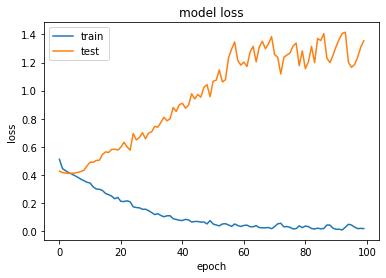

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's make predictions on the validation dataset to display the confusion matrix and calculate the F1 score:

43/43 [==============================] - 1s 7ms/step
F1 score = 0.6996268656716417


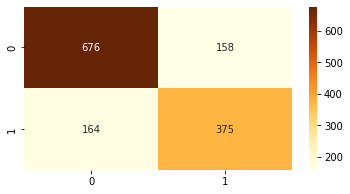

In [ ]:
val_scores = model.predict(x=X_val)
predictions = np.rint(val_scores)

print('F1 score = ' + str(f1_score(y_val, predictions)))

plt.figure(figsize = (6,3))
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt='d', cmap='YlOrBr')
plt.show()

# 7. Search for a better model

In [ ]:
for embedding_dim in (25, 50, 100):
    
    glove_file = 'drive/MyDrive/glove_twitter_27B_50d/glove.twitter.27B.' + str(embedding_dim) + 'd.txt'

    embedding={}
    with open(glove_file,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:],'float32')
            embedding[word] = vectors
    f.close()
    
    print('End loading embedding_' + str(embedding_dim) + 'd dictionary')
    
    if embedding_dim==25:
        embedding_25d = embedding
    elif embedding_dim==50:
        embedding_50d = embedding
    elif embedding_dim==100:
        embedding_100d = embedding

print('25d vector for \'ablaze\' : ' + str(embedding_25d['ablaze']))
print('50d vector for \'ablaze\' : ' + str(embedding_50d['ablaze']))
print('100d vector for \'ablaze\' : ' + str(embedding_100d['ablaze']))

End loading embedding_25d dictionary
End loading embedding_50d dictionary
End loading embedding_100d dictionary
25d vector for 'ablaze' : [-1.665     -0.29749    0.4721    -0.033642   0.0035009 -0.39495
 -0.84233   -2.0983     0.26166    0.40572    0.34332    0.87613
 -0.89234    1.0653    -0.2105     0.72415   -0.091988   0.68636
  1.2395    -0.8015    -0.47004    0.18046    0.29409   -0.46252
 -0.049161 ]
50d vector for 'ablaze' : [-1.3532   -0.077918  0.77155  -0.11099   0.62654   0.66574  -0.019857
 -0.30842  -0.15427  -0.88385  -0.3152    0.094996 -0.78936  -0.11191
  0.32219   0.013111  0.175     0.065855  0.53691  -0.9332    0.20486
 -0.64629  -0.52677  -0.24608   0.35051   1.07     -1.39      0.1717
 -0.43119   0.64184   0.39304   0.26976   0.70159  -0.24759   0.16952
 -0.75059   0.034953  0.61715  -0.49558  -0.44063   2.1116    0.67855
 -0.16697   0.60577   0.4629    0.03476  -0.11673  -0.20083   0.85643
  0.34675 ]
100d vector for 'ablaze' : [-2.0388e-01 -9.3451e-03 -9.0139e-

In [ ]:
# Returns the vectorization layer and the vocabulary size.
# Note : the vocabulary contains padding and out-of-vocabulary/unknown word
def get_vectorize_layer(train_ds):
    
    vectorize_layer = TextVectorization(output_mode="int")
    text_ds = train_ds.map(lambda x, y: x)
    vectorize_layer.adapt(text_ds)
    
    vocab_size = vectorize_layer.vocabulary_size()
    
    return vectorize_layer, vocab_size

In [ ]:
# Returns the embedding_matrix : word vectors for each word of the vocabulary.
# The dimension of the word vectors can be 25, 50 or 100.
# vectorize_layer : text vectorization layer adapted on the training set.
# vocab_size : should be vectorize_layer.vocabulary_size()
# embedding_dim : word vector size, can be 25, 50 or 100.
def get_embedding_matrix(vectorize_layer, vocab_size, embedding_dim):
    
    if embedding_dim==25:
        embedding = embedding_25d
    elif embedding_dim==50:
        embedding = embedding_50d
    elif embedding_dim==100:
        embedding = embedding_100d
        
    embedding_matrix = np.zeros((vocab_size, embedding_dim)) # size of embedding matrix = vocab_size. No need to add + 1 as the uknown/out-of-vocabulary word is in voca_size

    num_words_in_embedding = 0
    i = 0
    for word in vectorize_layer.get_vocabulary():
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector
        i+=1
        
    return embedding_matrix, num_words_in_embedding